# Singapore-Airline-Reviews

# Imports

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

np.random.seed(1)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

import torch

import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

# Functions

In [93]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  df[col].value_counts().plot.bar()
  
def remove_stop_words(review:str):

    word_tokens = " ".join(word_tokenize(review))
    filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', '', word_tokens).split(" ")
    
    filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence).strip()

# EDA Exploatory 

In [81]:
df = pd.read_csv("/Users/maukanmir/Downloads/singapore_airlines_reviews.csv")
df

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0
...,...,...,...,...,...,...,...
9995,2018-08-06T03:48:21-04:00,Desktop,5,review,First part done with Singapore Airlines - acce...,"Flew to NZ 1st half Singapore Airlines, 2nd ha...",1
9996,2018-08-05T22:50:29-04:00,Mobile,5,review,And again a great Flight with Singapore Air. G...,Best Airline,1
9997,2018-08-05T22:47:06-04:00,Desktop,5,review,"We flew business class from Frankfurt, via Sin...",Superb service on Singapore Airlines,1
9998,2018-08-05T20:32:03-04:00,Desktop,4,review,"As always, the A380 aircraft was spotlessly pr...",A Comfortable Fiight Spoiled by lack of adequa...,2


# Check for Nulls and Dupes

In [82]:
print(f"# Null values: {df.isna().sum()}")
print(f"# Dupe values: {df.duplicated().sum()}")

# Null values: published_date        0
published_platform    0
rating                0
type                  0
text                  0
title                 0
helpful_votes         0
dtype: int64
# Dupe values: 0


# Class Imbalance check

Class=3, Count=1009, Percentage=10.090%
Class=5, Count=5424, Percentage=54.240%
Class=1, Count=1057, Percentage=10.570%
Class=2, Count=543, Percentage=5.430%
Class=4, Count=1967, Percentage=19.670%


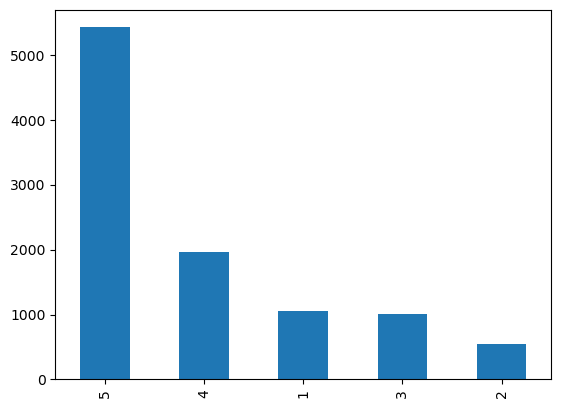

In [83]:
check_class_imbalance(df, df['rating'], 'rating')

# Data Preprocessing

In [84]:
df["text"] = df['text'].apply(remove_stop_words)
df["title"] = df['title'].apply(remove_stop_words)

In [85]:
# Reviews break down
df['review_char_count'] = df['text'].apply(lambda x: len(x))
df['review_num_of_words'] = df['text'].apply(lambda x: len(x.split(" ")))

# Title Break Down
df['title_char_count'] = df['title'].apply(lambda x: len(x))
df['title_num_of_words'] = df['title'].apply(lambda x: len(x.split(" ")))

# Time stamp conversion
df["published_date"] = pd.to_datetime(df['published_date'],errors='coerce', utc=True)

# Break Down into time frames
df['year'] = df["published_date"].dt.year
df['month'] = df["published_date"].dt.month
df['day'] = df["published_date"].dt.day

device_dummies = pd.get_dummies(df["published_platform"], prefix='platform')
df = pd.concat([df, device_dummies], axis=1)
df.drop(["published_platform","published_date", "type"], axis=1, inplace=True)

# Visual Analysis

<AxesSubplot:xlabel='review_num_of_words', ylabel='review_char_count'>

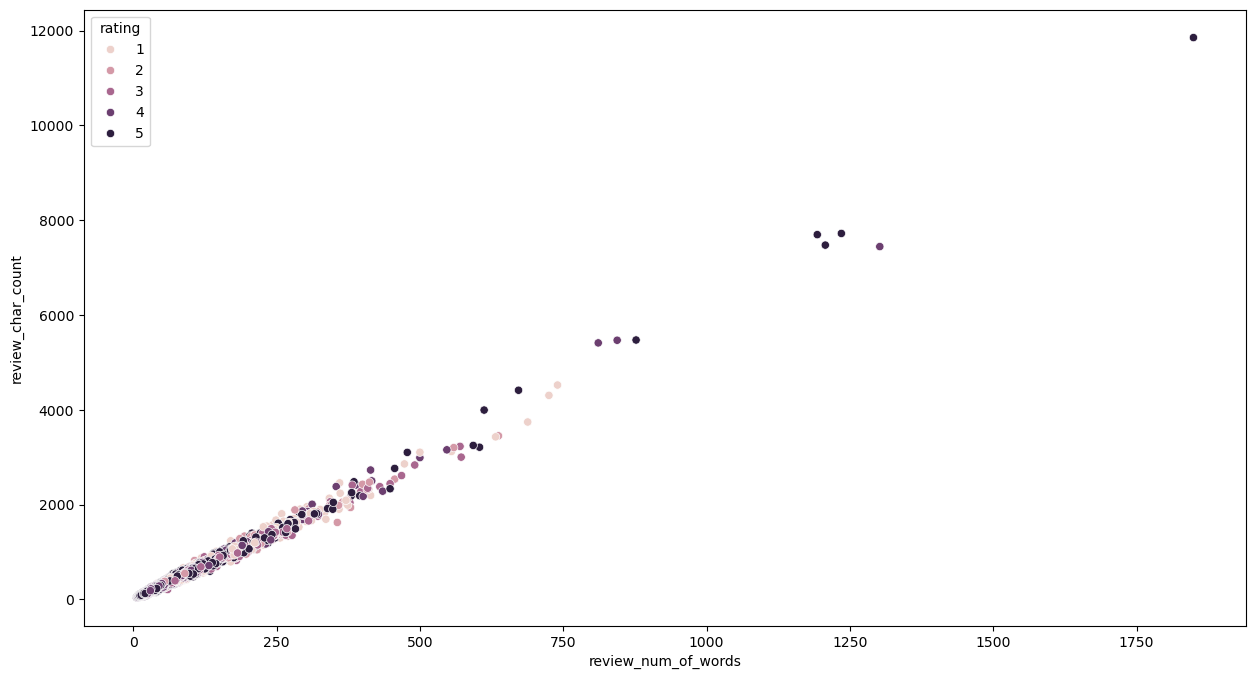

In [97]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x="review_num_of_words", y="review_char_count", hue="rating")

## The higher the number of words, the higher the rating

<AxesSubplot:xlabel='title_num_of_words', ylabel='title_char_count'>

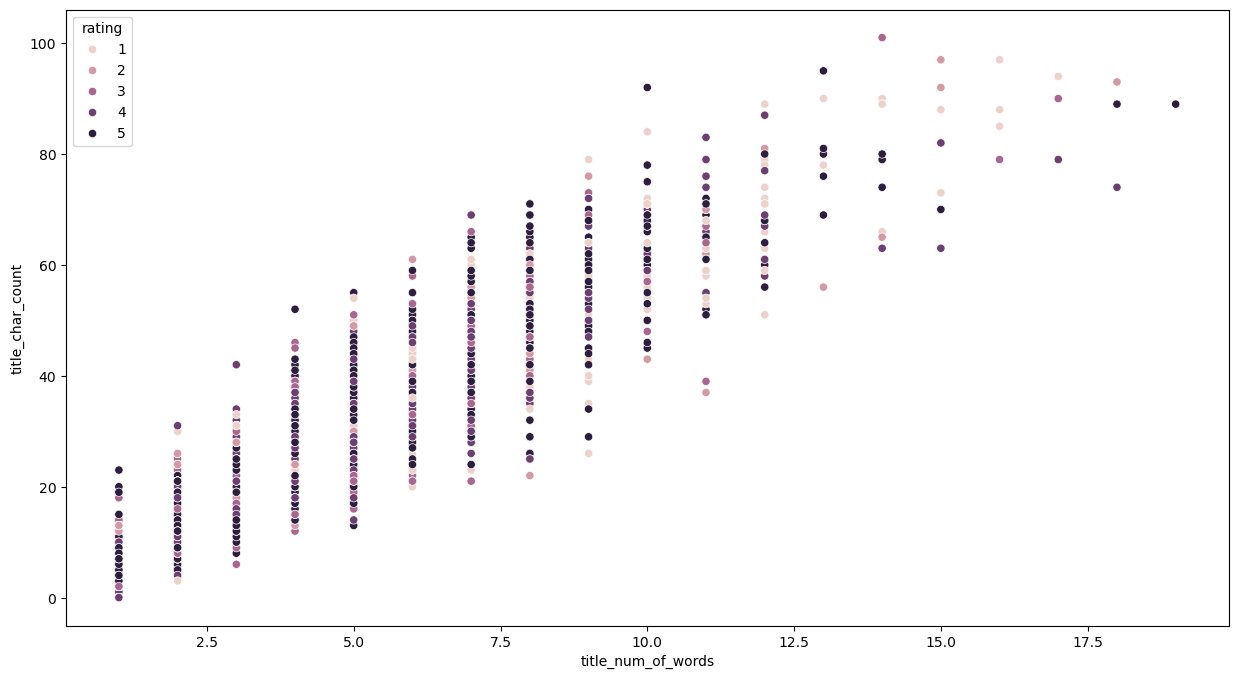

In [98]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x="title_num_of_words", y="title_char_count", hue="rating")

<AxesSubplot:xlabel='rating', ylabel='Count'>

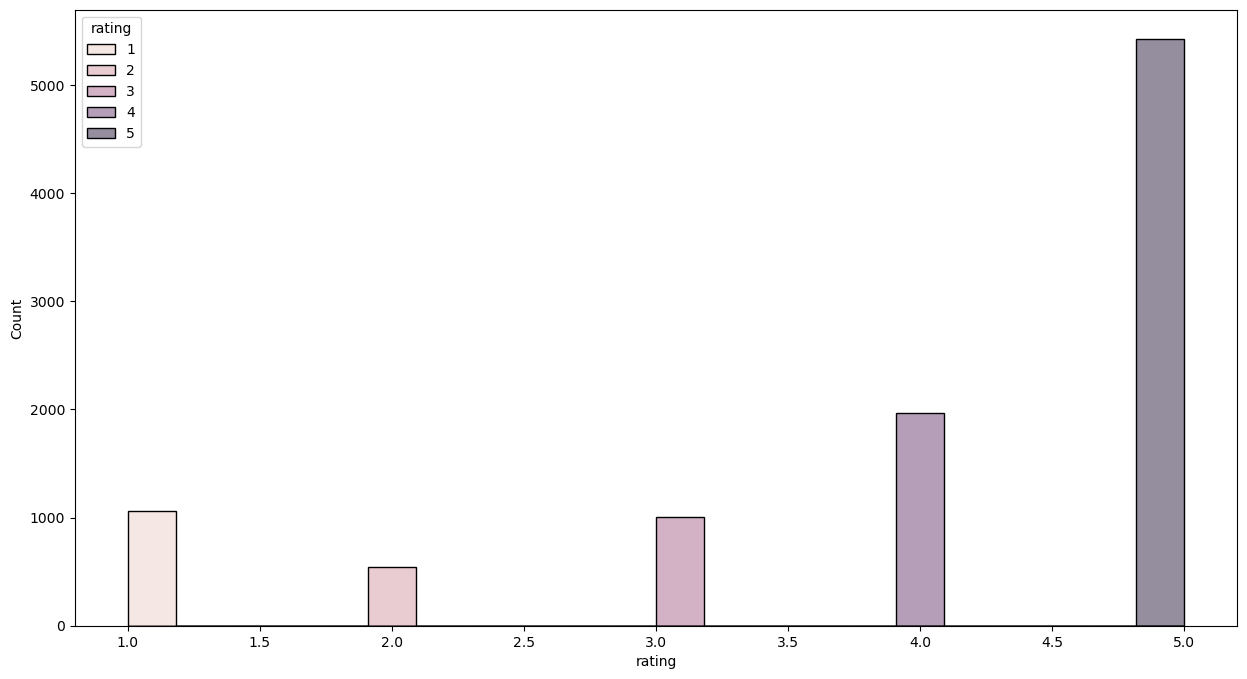

In [102]:
plt.figure(figsize=(15, 8))
sns.histplot(data=df, x="rating",kde=True, hue='rating')

In [99]:
df

,rating,text,title,helpful_votes,review_char_count,review_num_of_words,title_char_count,title_num_of_words,year,month,day,platform_Desktop,platform_Mobile
0,3,used airline singapore london heathrow issues...,ok,0,745,133,2,1,2024,3,12,1,0
1,5,service singapore airlines suites class excell...,service suites class makes feel like vip,0,2762,456,40,7,2024,3,11,1,0
2,1,booked paid received email confirmation extra...,don t money,0,293,55,12,4,2024,3,11,1,0
3,5,best airline world seats food service brill...,best airline world,0,107,19,18,3,2024,3,11,1,0
4,2,premium economy seating singapore airlines nar...,premium economy seating singapore airlines wor...,0,420,70,54,7,2024,3,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5,singapore airlines acceptable comfort level e...,flew nz st half singapore airlines nd half ai...,1,129,19,70,15,2018,8,6,1,0
9996,5,great flight singapore air great unique serv...,best airline,1,124,21,12,2,2018,8,6,0,1
9997,5,flew business class frankfurt singapore bris...,superb service singapore airlines,1,227,41,33,4,2018,8,6,1,0
9998,4,aircraft spotlessly presented boarding carpet...,comfortable fiight spoiled lack adequate meal ...,2,220,31,53,7,2018,8,6,1,0
